In [1]:
%matplotlib notebook
import copy
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import pickle as pkl
from os import listdir, makedirs
from os.path import isfile, join, exists
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [2]:
with open('data/allCompiledData.pkl', 'rb') as handle:
    is2data = pkl.load(handle)
ponds = list(is2data)
dfdepth = is2data['depth_all_df']

In [3]:
# correct for refractive index
ri = 1.33
dfdepth.iloc[:,[0,1,2,3,4,5,8,9]] /= ri
dfdepth['mean_algorithms'] = np.nanmean(dfdepth.iloc[:,[1,2,3,4,5,8]],axis=1)
dfdepth['mean_imagery'] = np.nanmean(dfdepth.iloc[:,[6,7]],axis=1)

<IPython.core.display.Javascript object>


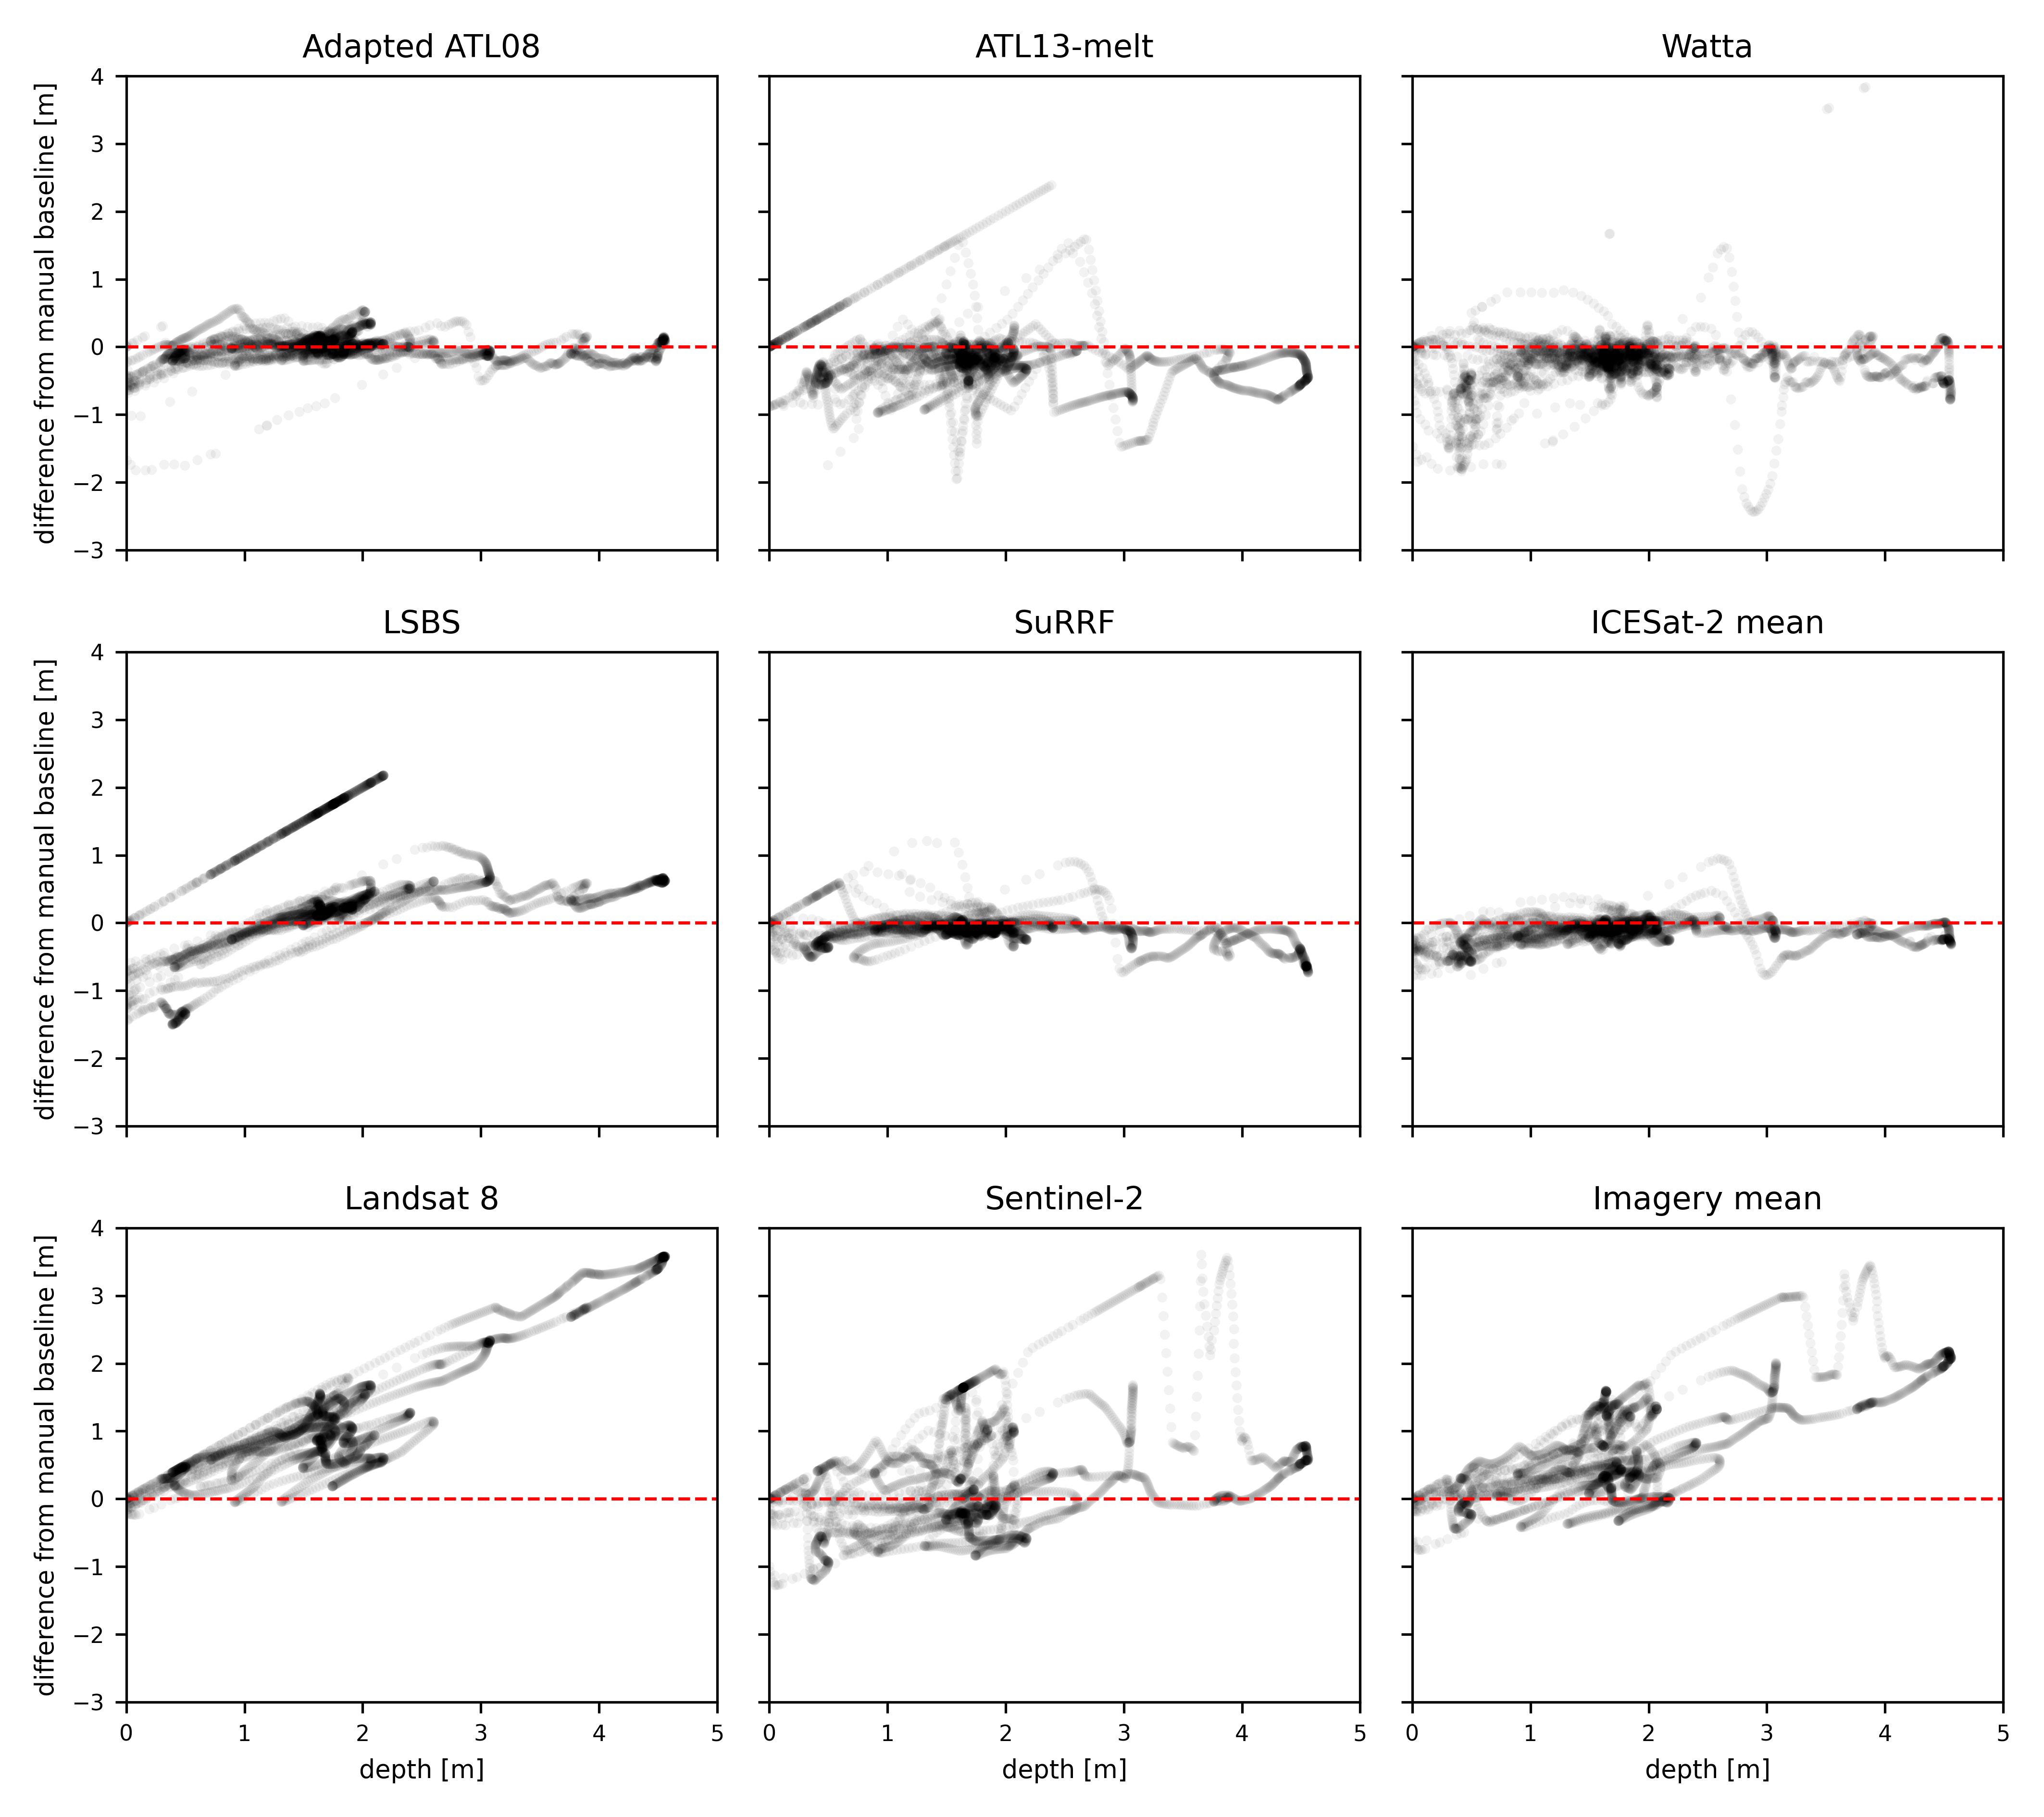

<IPython.core.display.Javascript object>


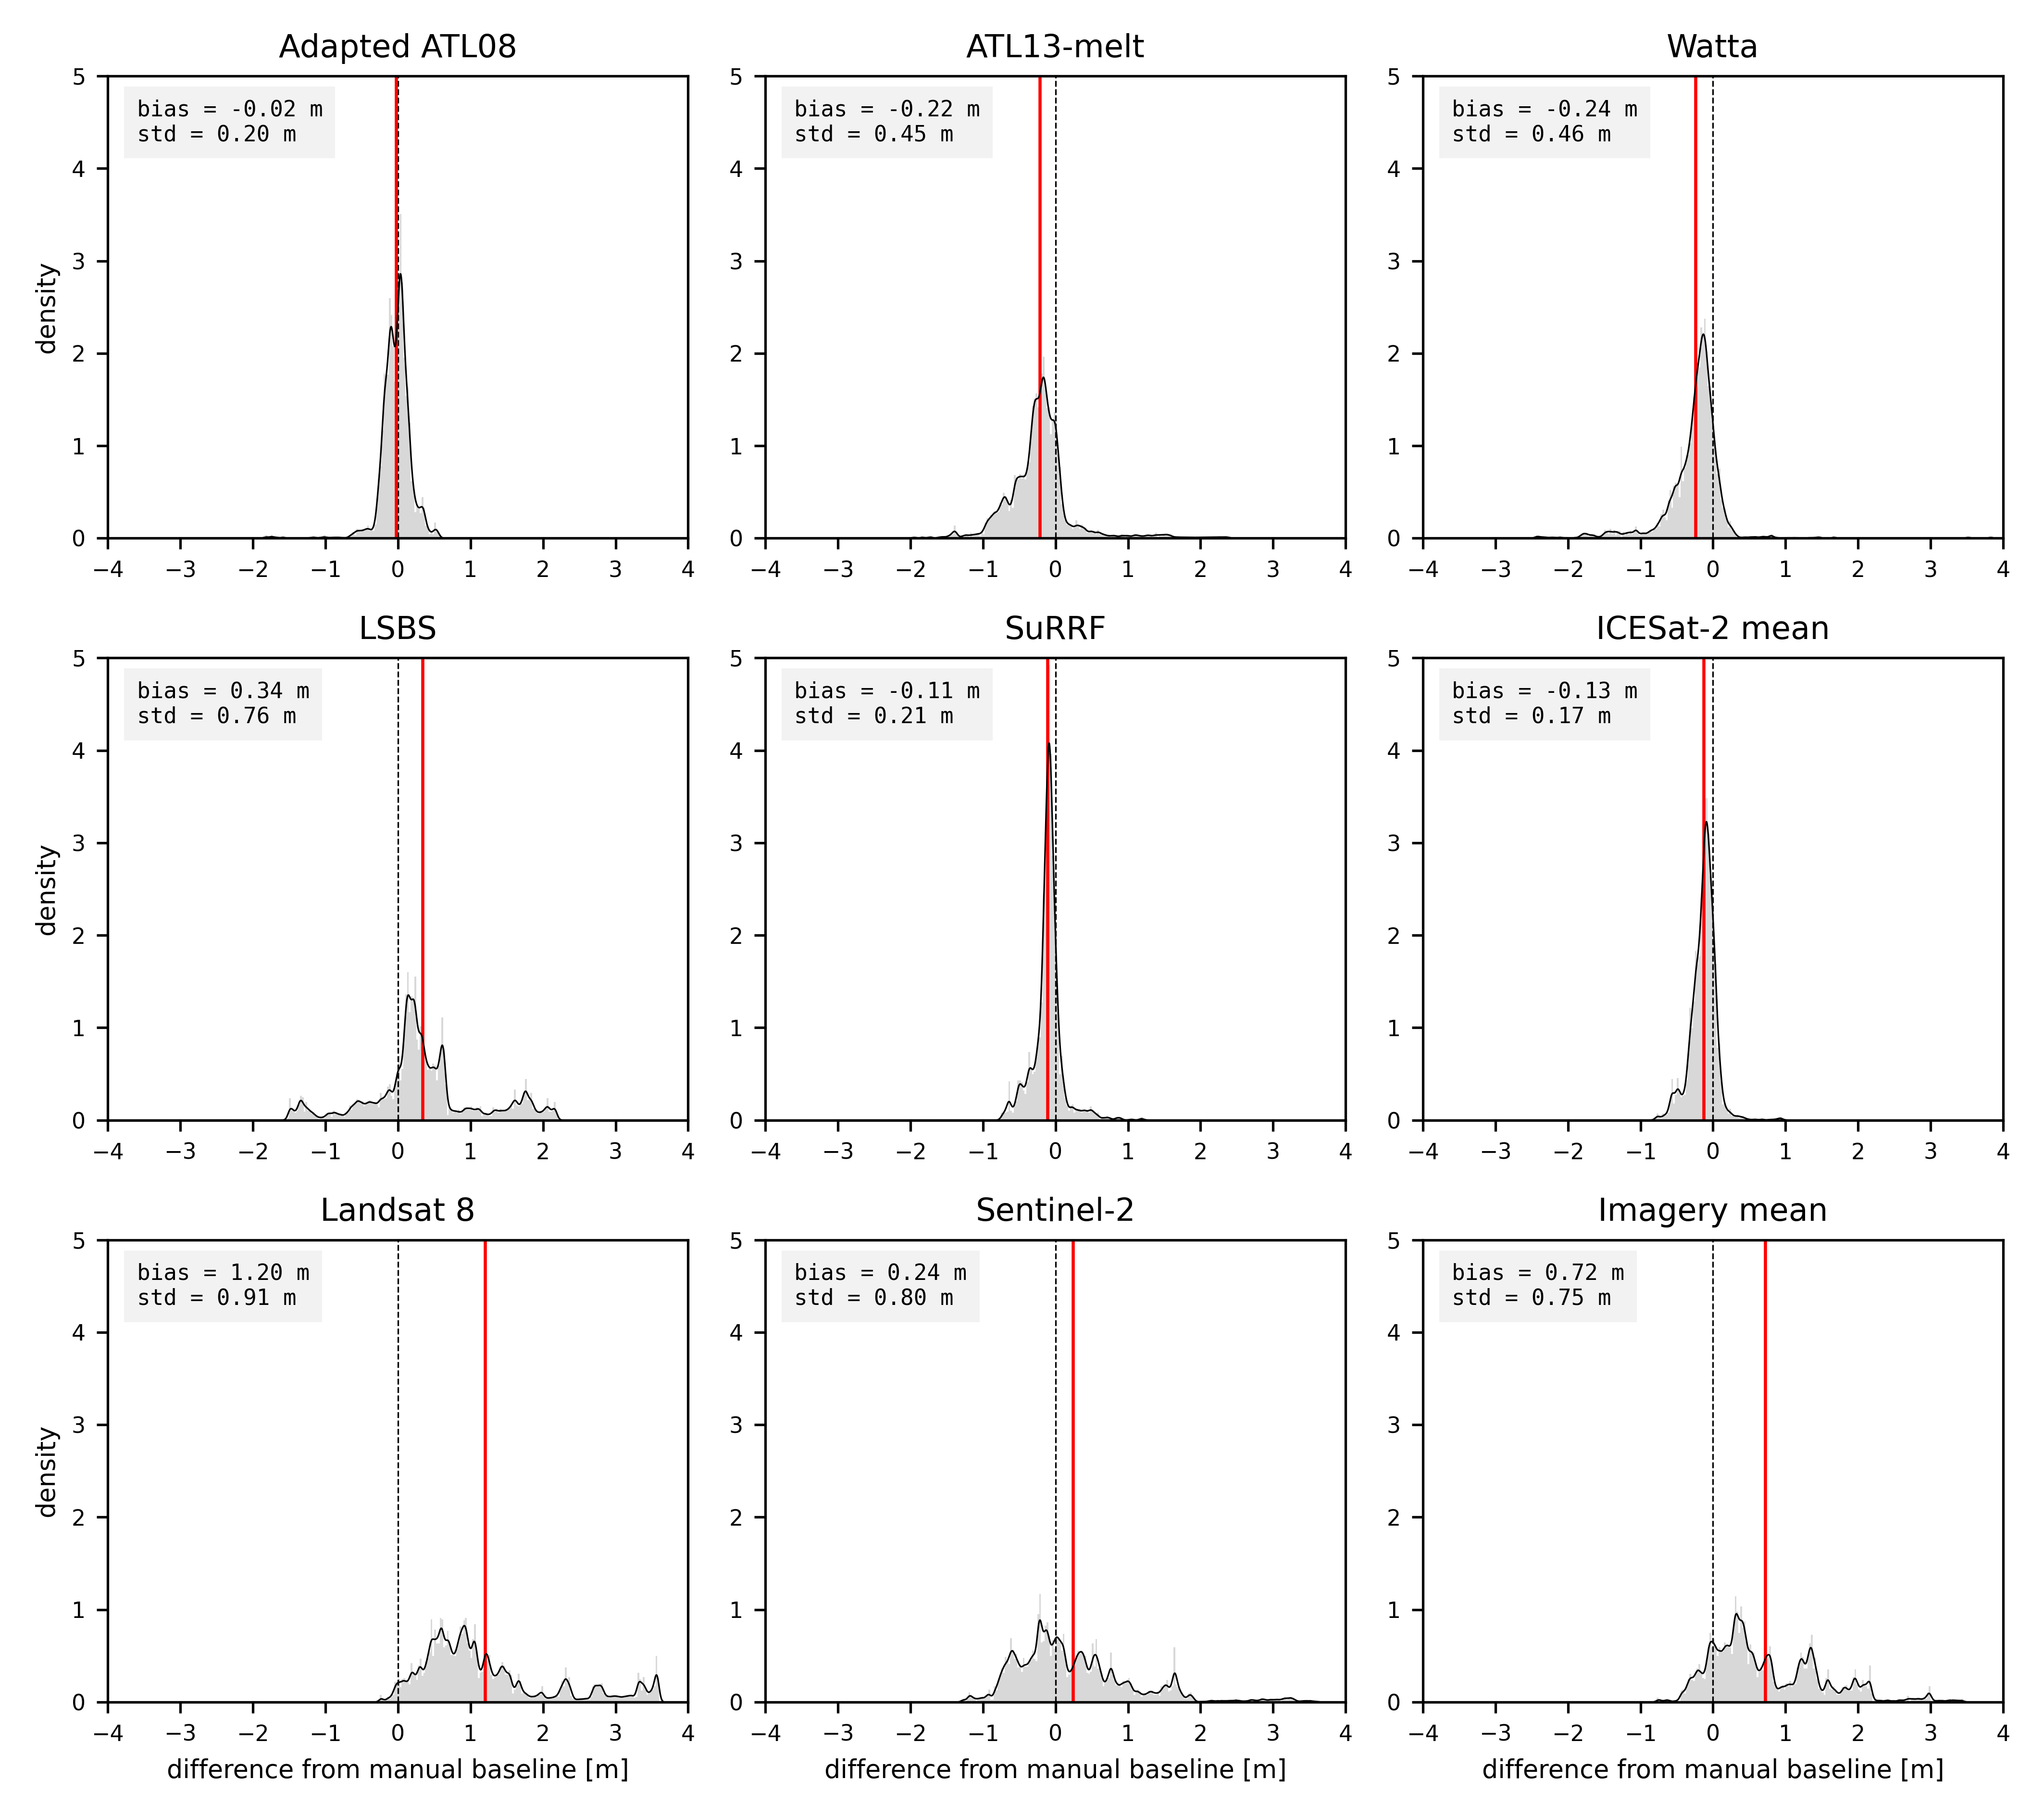

\begin{table}
\centering
\begin{tabular}{| r || c | c | c | c |}
\hline
Algorithm & RMSE & bias & std & correlation \\ \hline\hline
     Adapted ATL08 &  0.20 m & -0.02 m &  0.20 m &  0.990 \\ \hline
        ATL13-melt &  0.50 m & -0.22 m &  0.45 m &  0.946 \\ \hline
             Watta &  0.52 m & -0.24 m &  0.46 m &  0.941 \\ \hline
              LSBS &  0.83 m &  0.34 m &  0.76 m &  0.903 \\ \hline
             SuRRF &  0.23 m & -0.11 m &  0.21 m &  0.991 \\ \hline
     ICESat-2 mean &  0.22 m & -0.13 m &  0.17 m &  0.991 \\ \hline
         Landsat 8 &  1.51 m &  1.20 m &  0.91 m &  0.701 \\ \hline
        Sentinel-2 &  0.84 m &  0.24 m &  0.80 m &  0.820 \\ \hline
      Imagery mean &  1.04 m &  0.72 m &  0.75 m &  0.821 \\ \hline
\end{tabular}
\caption{Some statistics comparing different algorithms to the manual method.}
\end{table}


In [5]:
hiRes_output = True
names = ['magruder', 'jasinski', 'datta', 'fair_flanner', 'arndt', 'mean_algorithms',
         'spergel_kingslake', 'moussavi_pope', 'mean_imagery']
disp_names = ['Adapted ATL08', 'ATL13-melt', 'Watta', 'LSBS', 'SuRRF', 'ICESat-2 mean',
              'Landsat 8', 'Sentinel-2', 'Imagery mean']
use_pond_only = True

if hiRes_output:
    fig = plt.figure(figsize=[9, 8], dpi=300)
    fig2 = plt.figure(figsize=[9, 8], dpi=300)
else:
    fig = plt.figure(figsize=[9, 8])
    fig2 = plt.figure(figsize=[9, 8])

print('\\begin{table}\n\centering\n\\begin{tabular}{| r || c | c | c | c |}\n\hline')
print('Algorithm & RMSE & bias & std & correlation \\\\ \hline\hline')
for i,name in enumerate(names):
    ax = fig.add_subplot(3,3,i+1)
    ax2 = fig2.add_subplot(3,3,i+1)
    est = dfdepth[['manual',name]].copy()
    
    # if we want to just look at where there is a pond
    if use_pond_only:
        est = est.query('manual != 0')
    
    est[name].fillna(0,inplace=True)
    est['err'] = est['manual']-est[name]
    
    bias = np.nanmean(est.err)
    std = np.nanstd(est.err) 
    corr = dfdepth[['manual',name]].corr()
    corr = corr['manual'][name]
    
    rmse = np.sqrt(np.nanmean(est.err**2))
    mae = np.nanmean(np.abs(est.err))
    ax.scatter(est['manual'],est['err'],s=10,alpha=0.05,edgecolors='none',color='k')
    ax.plot([-0,5],[0,0],'r--',lw=1)
    ax.set_xlim((0,5))
    ax.set_ylim((-3,4))
    dispname = disp_names[i]
    ax2.set_title('%s' % dispname,fontsize=10)
    print('%18s & %5.2f m & %5.2f m & %5.2f m & %6.3f \\\\ \hline' % (dispname,rmse,bias,std,corr))
    ax.set_title('%s' % dispname,fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=7)
    if i > 5:
        ax.set_xlabel('depth [m]',fontsize=8)
    else:
        ax.axes.xaxis.set_ticklabels([])
    if i % 3 == 0:
        ax.set_ylabel('difference from manual baseline [m]',fontsize=8)
    else:
        ax.axes.yaxis.set_ticklabels([])
    
    yl = (0,5)
    ax2.plot((0,0),yl,'k--',lw=0.5)
    ax2.plot((bias,bias),yl,'r-',lw=1)
    ax2.hist(est.err,bins=np.arange(-5,5,0.025),color='gray',alpha=0.3,density=True)
    X_plot = np.arange(-5,5,0.001).reshape(-1, 1)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.03).fit(np.array(est.err).reshape(-1, 1))
    kde_dens = np.exp(kde.score_samples(X_plot))
    ax2.plot(X_plot,kde_dens,c='k',lw=0.5)
    ax2.set_xlim((-4,4))
    ax2.set_ylim(yl)
    ax2.set_title('%s' % dispname,fontsize=10)
    props = dict(facecolor='gray', alpha=0.1, linewidth=0)
#     ax2.text(0.05,0.95,'bias = %.2f m\nstd = %.2f m\nRMSE = %.2f m\ncorr = %.3f' % (bias,std,rmse,corr),
#              transform = ax2.transAxes,verticalalignment='top',horizontalalignment='left',fontsize=7,
#              family='monospace', bbox=props)
    ax2.text(0.05,0.95,'bias = %.2f m\nstd = %.2f m' % (bias,std),
             transform = ax2.transAxes,verticalalignment='top',horizontalalignment='left',fontsize=7,
             family='monospace', bbox=props)
    ax2.tick_params(axis='both', which='major', labelsize=7)
    if i > 5:
        ax2.set_xlabel('difference from manual baseline [m]',fontsize=8)
    else:
        ax.axes.xaxis.set_ticklabels([])
    if i % 3 == 0:
        ax2.set_ylabel('density',fontsize=8)
    else:
        ax.axes.yaxis.set_ticklabels([])
    
fig.tight_layout()
fig2.tight_layout()
print('\end{tabular}\n\caption{Some statistics comparing different algorithms to the manual method.}\n\end{table}')

if hiRes_output:
    plt.figure(fig.number)
    plt.savefig('figs/amery_melt_depth_vs_error.png')
    plt.figure(fig2.number)
    plt.savefig('figs/amery_melt_comparison_error_distributions.png')